# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

### <span style='color:#ff5f27'> 0.📝 Imports

In [11]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [12]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 18, 11, 57, 990407)

## <span style='color:#ff5f27'> 1.Download 

### <span style="color:#ff5f27;"> 1.1📡 Connect to Hopsworks Feature Store </span>

In [13]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1150100
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;"> 1.2⚙️ Feature View Retrieval</span>


In [14]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)


### <span style="color:#ff5f27;">1.3  Download the model from Model Registry</span>

In [15]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [16]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.596438E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">2. Inference: predict the future</span>



### <span style="color:#ff5f27;">2.0 Retrieve the weather predictions</span>

In [11]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-18 00:00:00+00:00,16.400000,0.5,12.074766,243.435013,toscana
1,2024-11-19 00:00:00+00:00,15.900000,0.1,26.729847,244.470337,toscana
2,2024-11-20 00:00:00+00:00,14.650000,0.1,22.862125,262.763184,toscana
3,2024-11-21 00:00:00+00:00,5.250000,2.9,18.193361,152.928009,toscana
4,2024-11-22 00:00:00+00:00,11.550000,0.3,13.089354,238.495789,toscana
5,2024-11-23 00:00:00+00:00,11.500000,0.0,4.680000,202.619904,toscana
6,2024-11-24 00:00:00+00:00,17.150000,0.0,25.417631,195.611053,toscana
7,2024-11-25 00:00:00+00:00,18.600000,0.1,9.504273,204.623550,toscana
8,2024-11-26 00:00:00+00:00,19.299999,0.0,15.716793,159.904678,toscana


### <span style="color:#ff5f27;">2.1 Making the predictions</span>

In [12]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-18 00:00:00+00:00,16.400000,0.5,12.074766,243.435013,toscana,39.221504
1,2024-11-19 00:00:00+00:00,15.900000,0.1,26.729847,244.470337,toscana,33.678894
2,2024-11-20 00:00:00+00:00,14.650000,0.1,22.862125,262.763184,toscana,32.159756
3,2024-11-21 00:00:00+00:00,5.250000,2.9,18.193361,152.928009,toscana,33.754105
4,2024-11-22 00:00:00+00:00,11.550000,0.3,13.089354,238.495789,toscana,40.764347
5,2024-11-23 00:00:00+00:00,11.500000,0.0,4.680000,202.619904,toscana,53.667244
6,2024-11-24 00:00:00+00:00,17.150000,0.0,25.417631,195.611053,toscana,33.658291
7,2024-11-25 00:00:00+00:00,18.600000,0.1,9.504273,204.623550,toscana,32.096260
8,2024-11-26 00:00:00+00:00,19.299999,0.0,15.716793,159.904678,toscana,35.867619


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">2.2 Saving the predictions (for monitoring) to a Feature Group</span>

In [14]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,16.400000,0.5,12.074766,243.435013,toscana,39.221504,pisa,italy,1
1,2024-11-19 00:00:00+00:00,15.900000,0.1,26.729847,244.470337,toscana,33.678894,pisa,italy,2
2,2024-11-20 00:00:00+00:00,14.650000,0.1,22.862125,262.763184,toscana,32.159756,pisa,italy,3
3,2024-11-21 00:00:00+00:00,5.250000,2.9,18.193361,152.928009,toscana,33.754105,pisa,italy,4
4,2024-11-22 00:00:00+00:00,11.550000,0.3,13.089354,238.495789,toscana,40.764347,pisa,italy,5
5,2024-11-23 00:00:00+00:00,11.500000,0.0,4.680000,202.619904,toscana,53.667244,pisa,italy,6
6,2024-11-24 00:00:00+00:00,17.150000,0.0,25.417631,195.611053,toscana,33.658291,pisa,italy,7
7,2024-11-25 00:00:00+00:00,18.600000,0.1,9.504273,204.623550,toscana,32.096260,pisa,italy,8
8,2024-11-26 00:00:00+00:00,19.299999,0.0,15.716793,159.904678,toscana,35.867619,pisa,italy,9


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

### <span style="color:#ff5f27;">2.3 Create Forecast graph</span>

2024-11-17 22:43:22,774 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



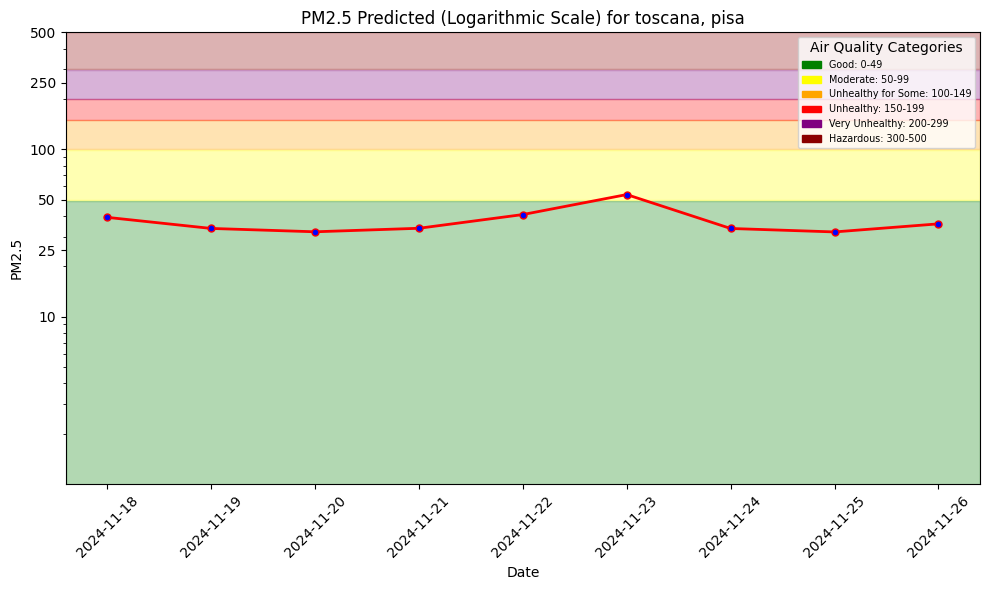

In [16]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

### <span style="color:#ff5f27;">2.4 Create Forecast FeatureGroup</span>

We do this part because we want to retrieve afterwards what's our prediction was during the week.

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [18]:
df = monitor_fg.read()
df.drop(['country','street','city'], axis = 1, inplace= True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


In [19]:
df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,10.550000,0.0,21.650938,42.978642,42.271626,1
1,2024-11-18 00:00:00+00:00,18.549999,0.1,18.584509,225.784729,26.123104,3
2,2024-11-12 00:00:00+00:00,15.000000,0.0,15.307410,48.814175,37.385159,8
3,2024-11-13 00:00:00+00:00,12.350000,0.0,16.923828,29.291269,40.452774,6
4,2024-11-19 00:00:00+00:00,18.700001,0.2,11.966954,195.708694,39.099037,5
5,2024-11-17 00:00:00+00:00,10.250000,0.2,4.896529,107.102814,88.454346,7
6,2024-11-20 00:00:00+00:00,15.250000,0.0,3.219938,243.435013,52.716785,9
7,2024-11-16 00:00:00+00:00,13.800000,0.0,2.276840,341.564941,56.060741,2
8,2024-11-15 00:00:00+00:00,12.800000,0.0,8.089993,20.854538,66.827866,4
9,2024-11-11 00:00:00+00:00,15.250000,0.0,17.076300,34.695221,34.874542,1


In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": False})

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,10.55,0.0,21.650938,42.978642,toscana,42.271626,pisa,italy,1
1,2024-11-11 00:00:00+00:00,15.25,0.0,17.076300,34.695221,toscana,34.874542,pisa,italy,1
2,2024-11-16 00:00:00+00:00,13.80,0.0,2.276840,341.564941,toscana,56.060741,pisa,italy,1
3,2024-11-18 00:00:00+00:00,16.40,0.5,12.074766,243.435013,toscana,39.221504,pisa,italy,1


In [27]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df.tail()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 


,date,pm25,country,city,street,url
2749,2024-11-12 00:00:00+00:00,59.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2750,2024-11-13 00:00:00+00:00,59.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2751,2024-11-15 00:00:00+00:00,59.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2752,2024-11-16 00:00:00+00:00,59.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2753,2024-11-17 00:00:00+00:00,59.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432


#### Merging the data

In [22]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-11 00:00:00+00:00,34.874542,72.0
1,2024-11-16 00:00:00+00:00,56.060741,59.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

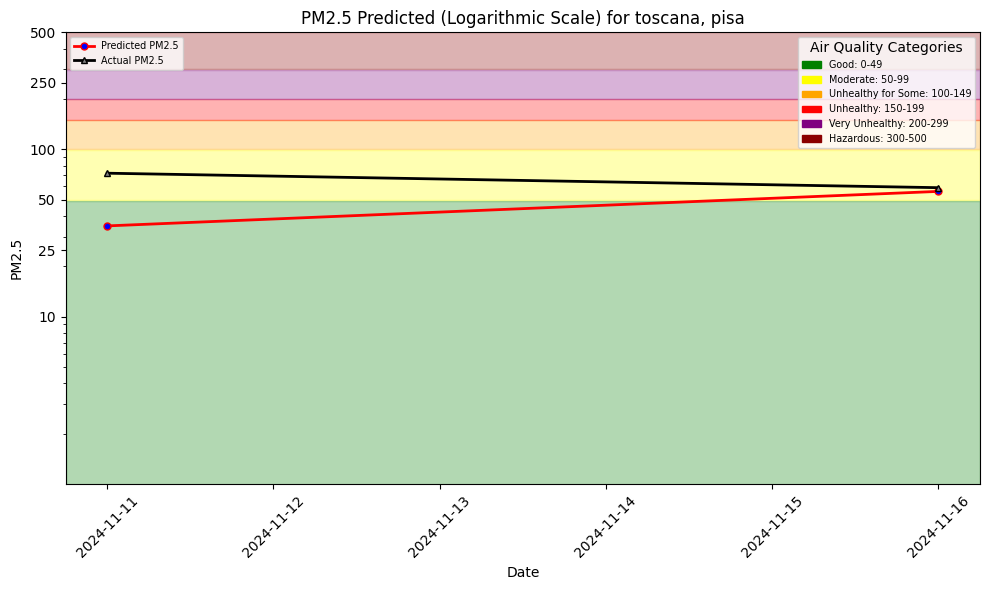

In [23]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---